# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

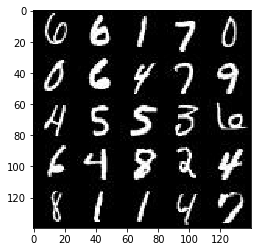

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

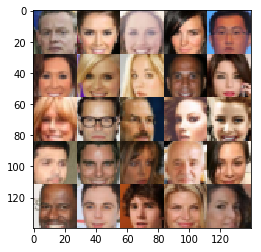

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input 28 x 28 x 3 
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
#         x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x =  tf.nn.dropout(x, keep_prob =0.8) 

        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x =  tf.nn.dropout(x, keep_prob =0.8) 
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x =  tf.nn.dropout(x, keep_prob =0.8) 
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse= not is_train):
        
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_real = discriminator(input_real)
    d_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real, labels=tf.ones_like(d_real) * (1 - smooth) ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake, labels=tf.zeros_like(d_fake) ))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake, labels=tf.ones_like(d_fake) ))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_list = tf.trainable_variables()
    g_vars = [var for var in vars_list if var.name.startswith("generator")]
    d_vars = [var for var in vars_list if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every = 10
    show_every = 100
    steps = 0
    
    # TODO: Build Model
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
   
            
    with tf.Session() as sess:
        
        input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
        d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Double value of batch_images
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    #Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 2.0945
Epoch 1/2... Discriminator Loss: 2.4731... Generator Loss: 0.2171
Epoch 1/2... Discriminator Loss: 2.0691... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.6496... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 1.4788
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 3.0247
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 1.8738
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.9428


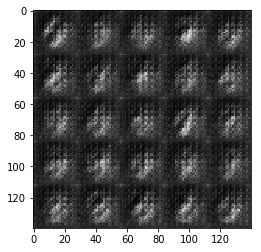

Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 1.1214
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 1.7217... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 1.3007


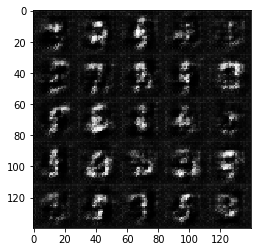

Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.8041


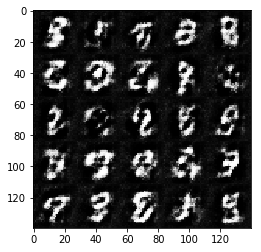

Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 1.6206... Generator Loss: 1.5686
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.9681


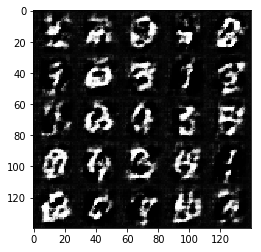

Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.7229


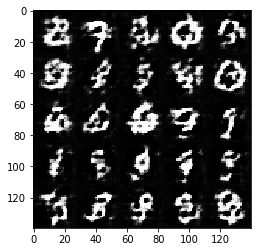

Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.8479
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.9986


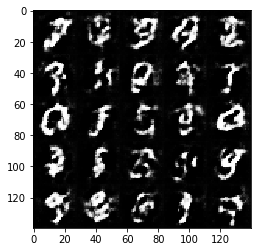

Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.2118
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.5457... Generator Loss: 0.4391
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 1.0780


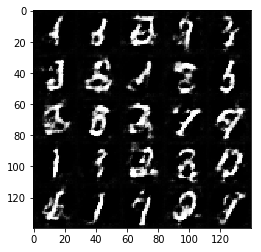

Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 0.4379
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.9646
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.6743


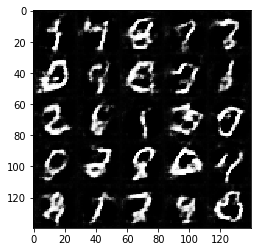

Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.7635


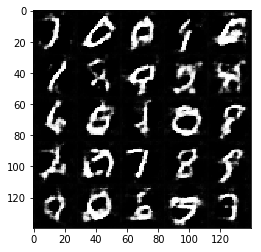

Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.8889


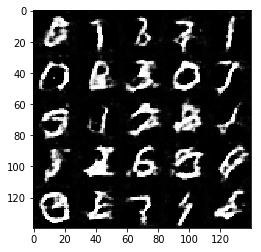

Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.6414


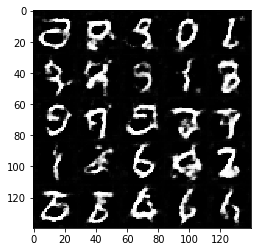

Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.9268


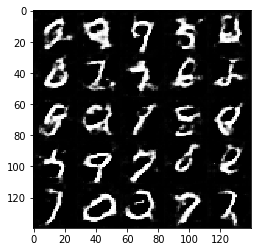

Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 1.1908
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 1.0993
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.6190


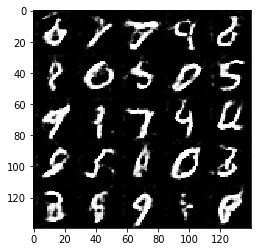

Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.9098


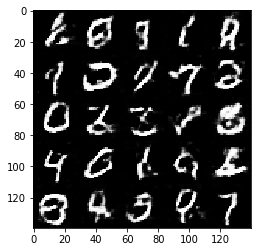

Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.0376
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.9334
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.6872


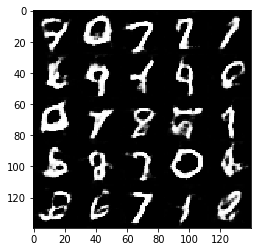

Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.7621


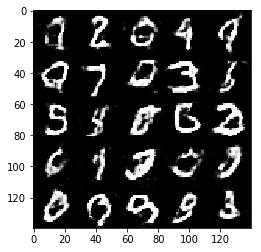

Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.6006
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.8393


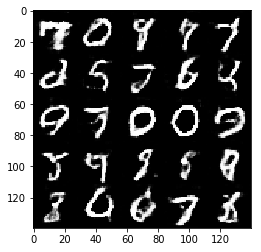

Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 1.1117
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 1.0475


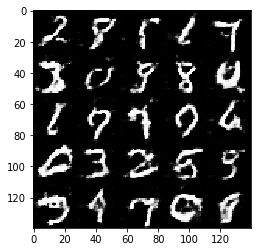

Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 1.1017
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.6409


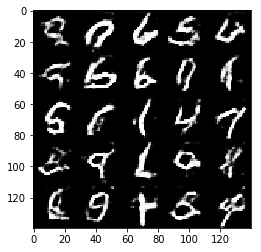

Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.9775
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.5354... Generator Loss: 0.4861
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 0.9499


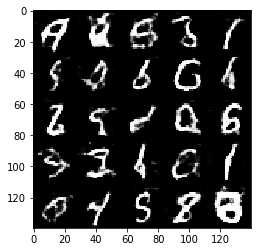

Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.4960... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 1.0421


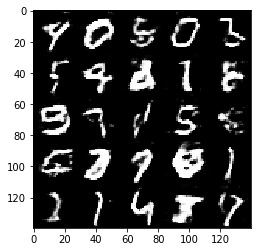

Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.5191... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.6208


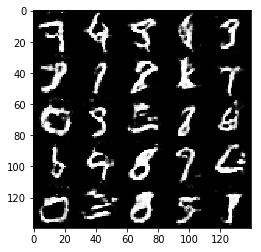

Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.9557... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.9938
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.6714


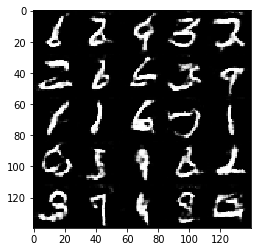

Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 1.1531
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.6776


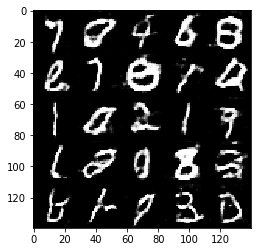

Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.8471
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.9352


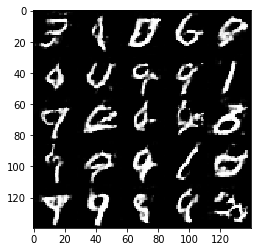

Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 1.3959
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.7370
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.6192... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.8793


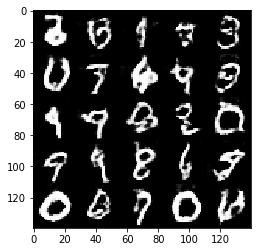

Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 1.1092


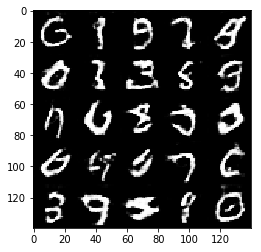

Epoch 2/2... Discriminator Loss: 1.1890... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.9380
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.7548... Generator Loss: 0.3634
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.7718


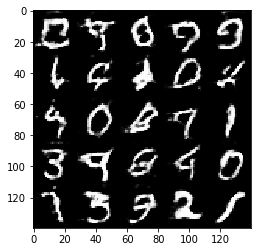

Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.9385


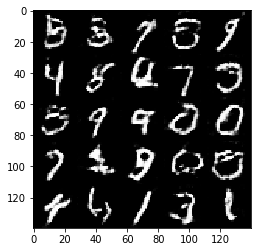

Epoch 2/2... Discriminator Loss: 1.1203... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.0937
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.9393
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.5864


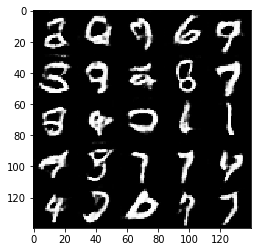

Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 1.7672... Generator Loss: 0.3355
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7678


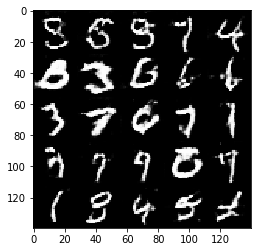

Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 1.0752
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.8623
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 1.0725
Epoch 2/2... Discriminator Loss: 1.8988... Generator Loss: 0.3419
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.0093


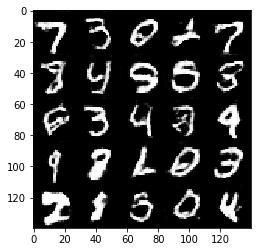

Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.7572


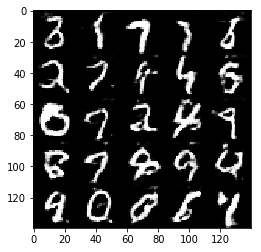

Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 1.1247
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 1.0096
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 1.0396


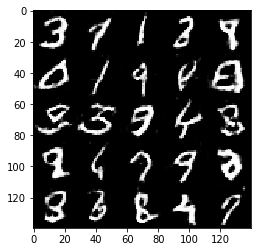

Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 1.3920
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.0290
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.6970


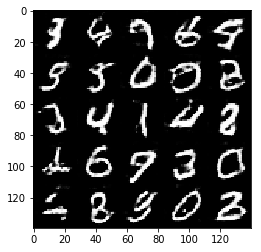

Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.9568
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.6558... Generator Loss: 0.4107
Epoch 2/2... Discriminator Loss: 1.1057... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 1.2275
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.9695


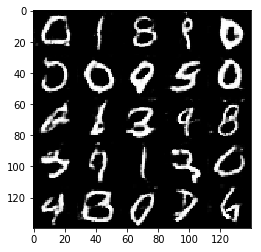

Epoch 2/2... Discriminator Loss: 1.1543... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.9075


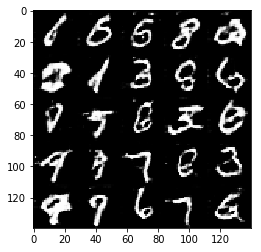

Epoch 2/2... Discriminator Loss: 1.6954... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.0345
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.6759


In [12]:
batch_size =  32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.7844... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 3.2170
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 2.5804
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.0003


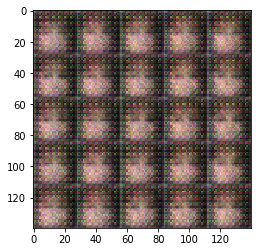

Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.3075
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 2.2593
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 2.4882
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 2.0303
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 2.2008


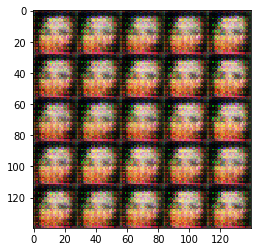

Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.5215
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.8066
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.9027
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.9595
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 2.0907
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 2.0178
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 2.2441
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.2713


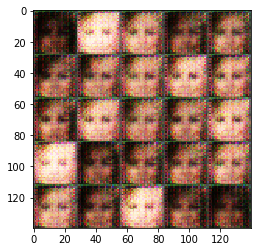

Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 2.1839
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.6372
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 2.4953
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.8484
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7051


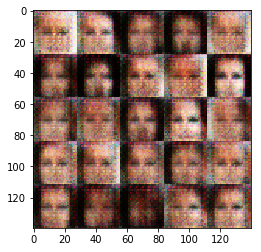

Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.3802


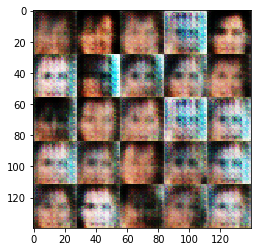

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6876


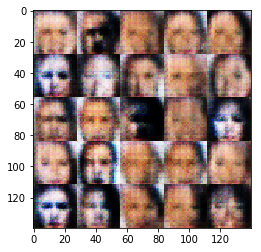

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.7327... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.9347


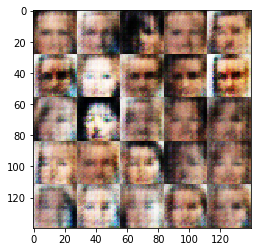

Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.9422


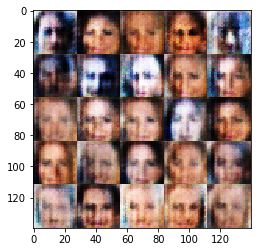

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7139


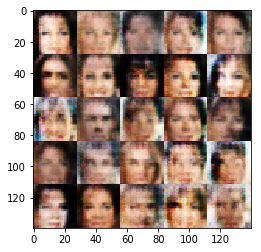

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5613


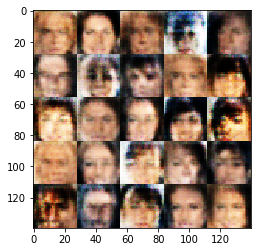

Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8642


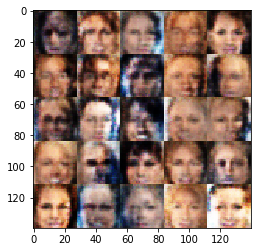

Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.5657


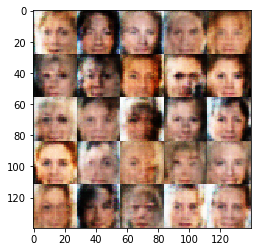

Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8672


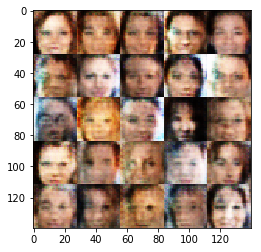

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5320


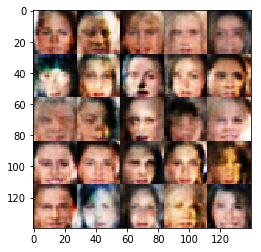

Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6954


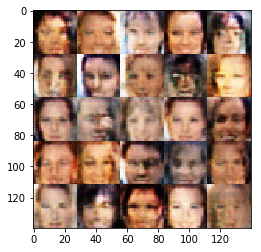

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7653


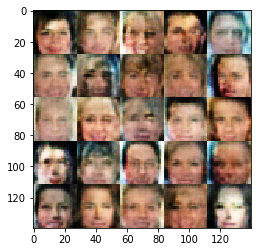

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8383


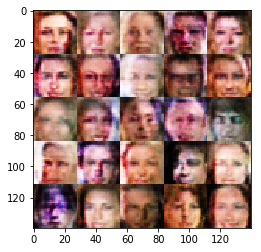

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8749


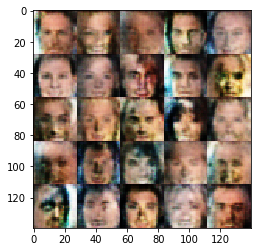

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7140


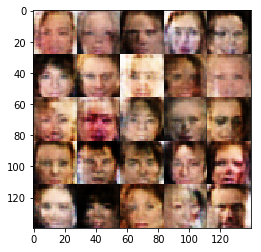

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9072


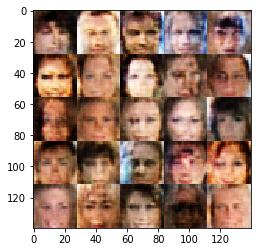

Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6175


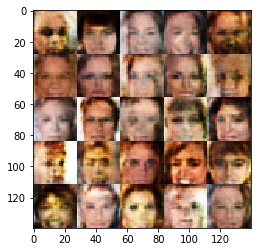

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.7279


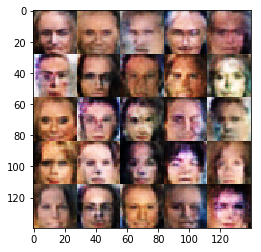

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6854


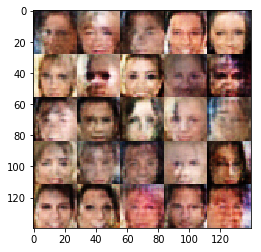

Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6401


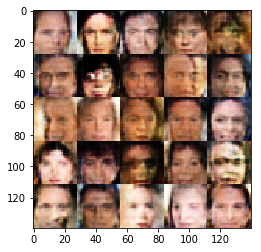

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9086


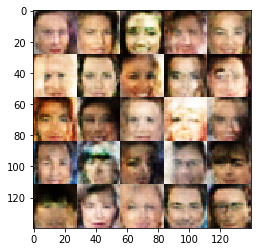

Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8458


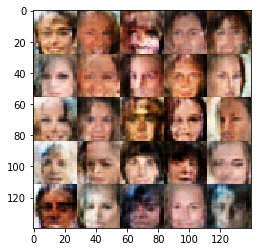

Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.4331


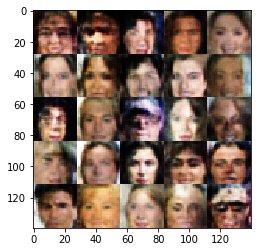

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6907


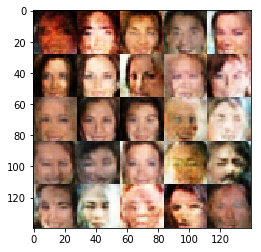

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7942


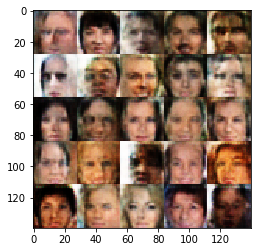

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7172


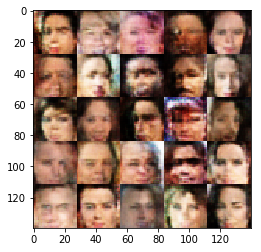

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7562


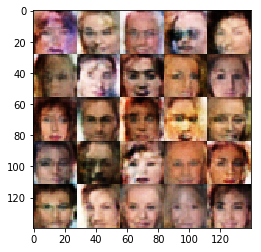

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.7472... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9284


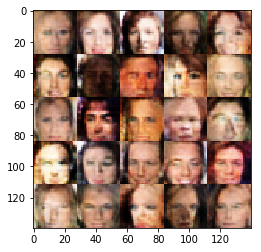

Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.7774... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8340


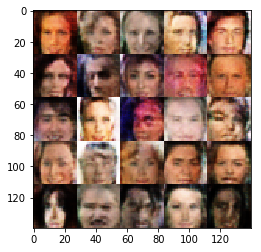

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7787


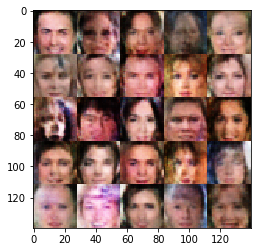

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7419


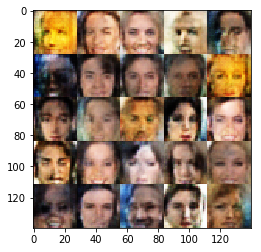

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6522


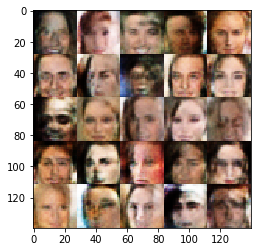

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7013


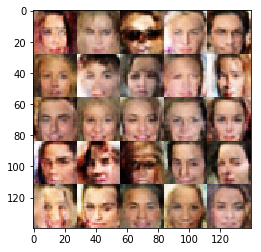

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5737


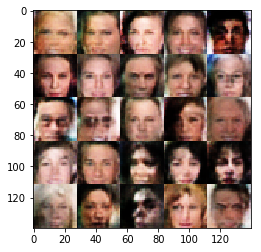

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8143


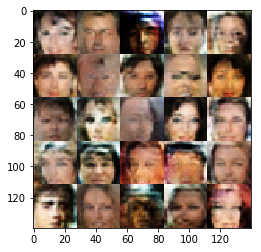

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5890


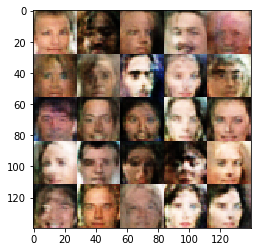

Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7147


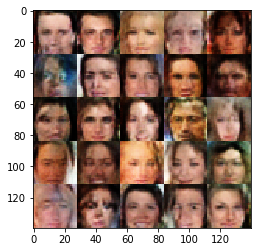

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5448


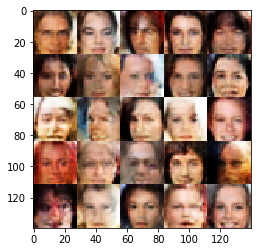

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7833


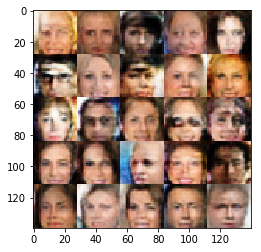

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9837


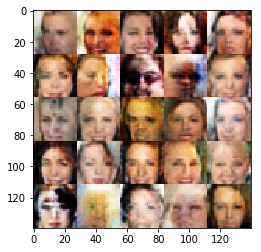

Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7742


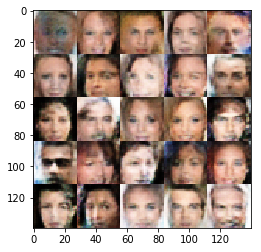

Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9504


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.